In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


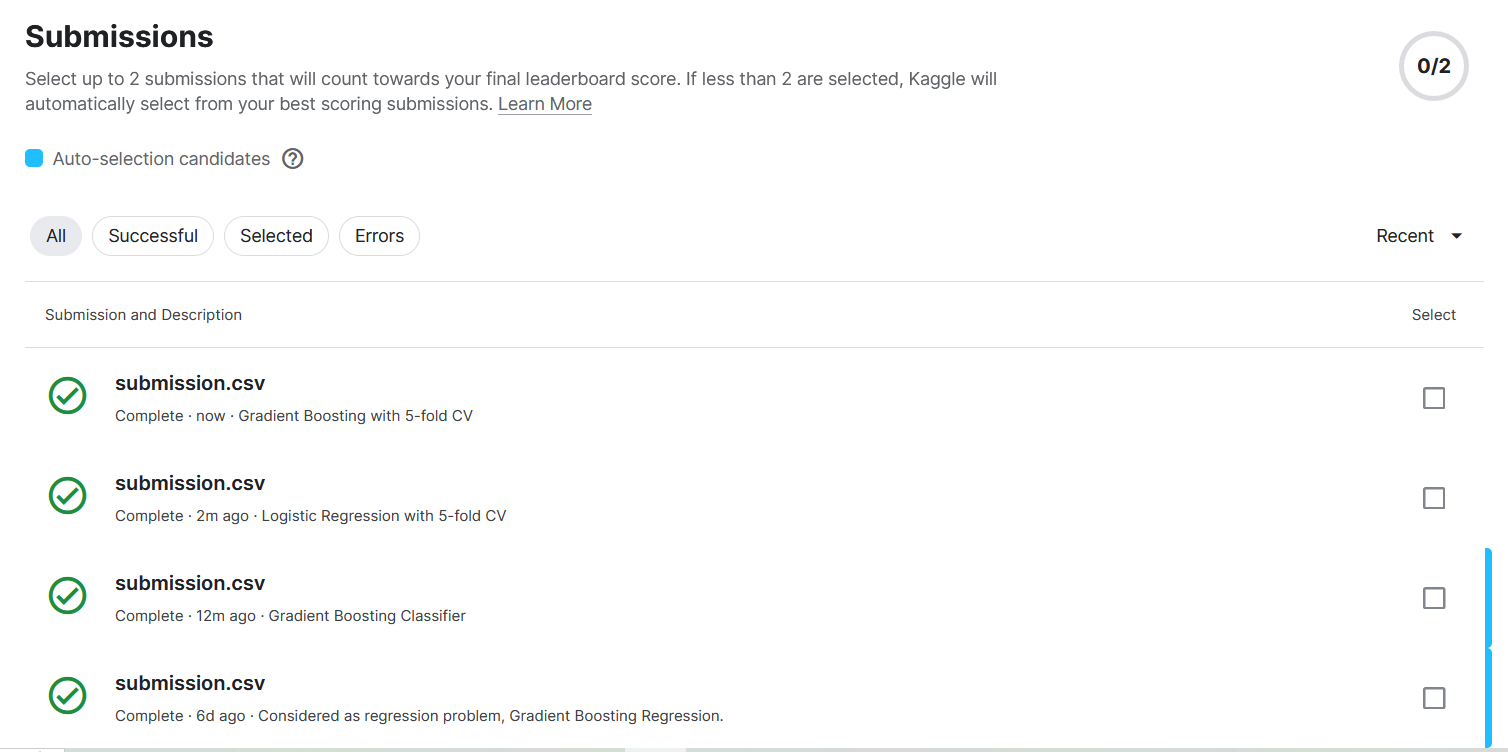

In [2]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *
import matplotlib.pyplot as plt


import os

Reference for Data Pre-processing:https://www.kaggle.com/code/benjenkins96/deep-learning-techniques-to-predict-march-madness

In [3]:
DATA_PATH = '/content/gdrive/MyDrive/Practical ML/Project_02/Data/KaggleData/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Conferences.csv
NCAATourneyCompactResults.csv
NCAATourneySeeds.csv
RegularSeasonCompactResults.csv
SampleSubmission2023.csv
TeamConferences.csv
Teams.csv
WNCAATourneyCompactResults.csv
WNCAATourneySeeds.csv
WRegularSeasonCompactResults.csv


In [4]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "NCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "RegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1985,20,1228,81,1328,64
1,1985,25,1106,77,1354,70
2,1985,25,1112,63,1223,56
3,1985,25,1165,70,1432,54
4,1985,25,1192,86,1447,74
...,...,...,...,...,...,...
306274,2023,113,3268,96,3234,68
306275,2023,113,3385,69,3163,64
306276,2023,113,3416,57,3396,53
306277,2023,113,3437,67,3177,64


In [6]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']
df_season_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12
...,...,...,...,...,...,...,...
306274,2023,113,3268,96,3234,68,28
306275,2023,113,3385,69,3163,64,5
306276,2023,113,3416,57,3396,53,4
306277,2023,113,3437,67,3177,64,3


In [7]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
num_win

,Season,TeamID,NumWins
0,1985,1102,5
1,1985,1103,9
2,1985,1104,21
3,1985,1106,10
4,1985,1108,19
...,...,...,...
21377,2023,3473,1
21378,2023,3474,5
21379,2023,3475,8
21380,2023,3476,7


In [8]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [9]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [10]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [11]:
# Merge all dfs together 
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

# Fil NAs with 0's
df_features_season.fillna(0, inplace=True)  

In [12]:
# Create features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

In [13]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "NCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [14]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


In [15]:
# SeedL is losing team and SeedW is winning team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [16]:

import re
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)
df.head(30)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,12,5
1,2016,137,3113,74,3308,52,2,15
2,2016,137,3120,68,3385,57,9,8
3,2016,137,3124,89,3225,59,1,16
4,2016,137,3177,97,3241,67,6,11
5,2016,137,3243,56,3203,51,9,8
6,2016,137,3257,87,3146,60,3,14
7,2016,137,3277,74,3125,60,4,13
8,2016,137,3280,60,3151,50,5,12
9,2016,137,3326,88,3138,69,3,14


In [17]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

df.head(30)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250
5,2016,137,3243,56,3203,51,9,8,0.600000,3.933333,0.812500,9.656250
6,2016,137,3257,87,3146,60,3,14,0.781250,12.718750,0.888889,9.111111
7,2016,137,3277,74,3125,60,4,13,0.750000,11.812500,0.733333,10.266667
8,2016,137,3280,60,3151,50,5,12,0.787879,15.939394,0.774194,5.322581
9,2016,137,3326,88,3138,69,3,14,0.774194,12.258065,0.606061,1.060606


In [18]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

df = add_loosing_matches(df)
df.head(30)

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250
5,2016,137,3243,56,3203,51,9,8,0.600000,3.933333,0.812500,9.656250
6,2016,137,3257,87,3146,60,3,14,0.781250,12.718750,0.888889,9.111111
7,2016,137,3277,74,3125,60,4,13,0.750000,11.812500,0.733333,10.266667
8,2016,137,3280,60,3151,50,5,12,0.787879,15.939394,0.774194,5.322581
9,2016,137,3326,88,3138,69,3,14,0.774194,12.258065,0.606061,1.060606


In [19]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [20]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

df_test.head(30)

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
5,2023_1101_1107,0.5,2023,1101,1107
6,2023_1101_1108,0.5,2023,1101,1108
7,2023_1101_1110,0.5,2023,1101,1110
8,2023_1101_1111,0.5,2023,1101,1111
9,2023_1101_1112,0.5,2023,1101,1112


In [21]:


df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test.head(30)



,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,1,1
1,2023_1101_1103,0.5,2023,1101,1103,1,1
2,2023_1101_1104,0.5,2023,1101,1104,1,1
3,2023_1101_1105,0.5,2023,1101,1105,1,1
4,2023_1101_1106,0.5,2023,1101,1106,1,1
5,2023_1101_1107,0.5,2023,1101,1107,1,1
6,2023_1101_1108,0.5,2023,1101,1108,1,1
7,2023_1101_1110,0.5,2023,1101,1110,1,1
8,2023_1101_1111,0.5,2023,1101,1111,1,1
9,2023_1101_1112,0.5,2023,1101,1112,1,1


In [22]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [23]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2023_1101_1102,0.5,2023,1101,1102,1,1,0.409091,-2.863636,0.482759,0.241379
1,2023_1101_1103,0.5,2023,1101,1103,1,1,0.409091,-2.863636,0.653846,5.653846
2,2023_1101_1104,0.5,2023,1101,1104,1,1,0.409091,-2.863636,0.851852,15.111111
3,2023_1101_1105,0.5,2023,1101,1105,1,1,0.409091,-2.863636,0.360000,-3.560000
4,2023_1101_1106,0.5,2023,1101,1106,1,1,0.409091,-2.863636,0.259259,-9.703704
...,...,...,...,...,...,...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476,1,1,0.217391,-13.347826,0.269231,-6.923077
130679,2023_3474_3477,0.5,2023,3474,3477,1,1,0.217391,-13.347826,0.423077,-5.000000
130680,2023_3475_3476,0.5,2023,3475,3476,1,1,0.333333,-3.125000,0.269231,-6.923077
130681,2023_3475_3477,0.5,2023,3475,3477,1,1,0.333333,-3.125000,0.423077,-5.000000


In [24]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']
    
# Compute Difference in Final Score (ScoreDiff) and whether or not the team won (WinA)
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [25]:


# Split data in X and y
X = df[["SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff']]
y = df[['WinA']]



In [26]:
y

,WinA
0,1
1,1
2,1
3,1
4,1
...,...
778,0
779,0
780,0
781,0


In [27]:
X = df.drop(columns=['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB',
                    'WinA', 'ScoreDiff'])
y = df['WinA']

In [29]:
from sklearn.model_selection import train_test_split


# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
X_train

,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff
570,11,7,0.843750,9.656250,0.794118,10.205882,4,0.049632,-0.549632
84,13,4,0.677419,5.645161,0.794118,14.882353,9,-0.116698,-9.237192
4,11,6,0.843750,15.406250,0.757576,16.272727,5,0.086174,-0.866477
459,5,12,0.727273,6.181818,0.878788,10.909091,-7,-0.151515,-4.727273
777,2,5,0.787879,9.545455,0.852941,16.941176,-3,-0.065062,-7.395722
...,...,...,...,...,...,...,...,...,...
347,6,11,0.633333,6.966667,0.851852,17.814815,-5,-0.218519,-10.848148
511,2,1,0.852941,14.352941,0.787879,13.424242,1,0.065062,0.928699
77,14,3,0.846154,11.730769,0.741935,12.354839,11,0.104218,-0.624069
676,15,2,0.700000,9.600000,0.724138,11.827586,13,-0.024138,-2.227586


In [31]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [32]:
def rescale(features, df_train, df_val):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    
    #df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val

In [33]:
df_train, df_val= rescale(features, X_train, X_test)

In [34]:
df_train.shape

(1252, 9)

In [35]:
df_test_new=df_test[features]
df_test_new.shape

(130683, 9)

In [36]:
min_ = df_train[features].min()
max_ = df_train[features].max()
df_test_new[features] = (df_test_new[features] - min_) / (max_ - min_)

<ipython-input-36-4cd96a32685e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_new[features] = (df_test_new[features] - min_) / (max_ - min_)


Applied an Gradient Boosting Regression Model

In [37]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(df_train, y_train)

GradientBoostingRegressor(random_state=0)

In [38]:
reg.predict(df_val)

array([ 0.53513053,  0.20812542,  0.12149523,  0.62786158,  0.28813951,
        0.44090949,  0.61241363,  0.4145795 ,  0.10799955,  0.58616406,
        0.28922307, -0.0688765 ,  0.70545056,  0.24497137,  0.6269844 ,
        0.01106809,  0.8406515 ,  1.05758897,  0.62164216,  0.36362094,
        0.30449696,  0.38260108,  0.92312863,  0.9784605 ,  0.65116449,
        0.33732264,  0.97547153,  0.31047266,  0.97419683,  0.63427795,
        1.00270462, -0.00847653,  0.29590267,  0.89776539,  1.00766536,
        0.59563785,  0.78393629,  0.62885606,  0.88322473,  0.57481101,
        0.12564999,  0.4674005 ,  0.27752476,  0.54185158,  0.0478539 ,
        1.01965118,  0.73269725,  0.82873682,  0.93998684,  0.57830624,
       -0.02842922,  0.51831679,  0.45427956,  0.66985681,  0.47353299,
        0.33748421,  0.66612671,  0.45567072,  0.76875222,  0.48737177,
        0.2402861 ,  0.28673811,  0.3805183 ,  0.9114705 ,  0.54372716,
        0.39150324,  0.28578623,  0.58047339,  0.83726835,  0.71

In [39]:
reg.score(df_val, y_test)

0.2562077650254512

In [40]:
preds=reg.predict(df_test_new)

In [41]:
df_test['pred'] = preds

In [43]:
final_sub = df_test[['ID', 'pred']].copy()

In [44]:
final_sub.shape

(130683, 2)

In [45]:
final_sub.head(20)

,ID,pred
0,2023_1101_1102,0.386611
1,2023_1101_1103,0.316531
2,2023_1101_1104,0.292150
3,2023_1101_1105,0.411926
4,2023_1101_1106,0.535427
5,2023_1101_1107,0.409911
6,2023_1101_1108,0.554932
7,2023_1101_1110,0.491284
8,2023_1101_1111,0.362530
9,2023_1101_1112,0.292150


In [ ]:
final_sub.to_csv('/content/gdrive/MyDrive/Practical ML/Project_02/submission.csv', index=False)

Applying a classification Model

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100)
gbc.fit(df_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=500,
                           random_state=100)

In [47]:
from sklearn.metrics import classification_report

pred=gbc.predict(df_val)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.68      0.67      0.67       164
           1       0.64      0.65      0.65       150

    accuracy                           0.66       314
   macro avg       0.66      0.66      0.66       314
weighted avg       0.66      0.66      0.66       314



In [48]:
preds=gbc.predict_proba(df_test_new)
preds

array([[0.52730972, 0.47269028],
       [0.90479673, 0.09520327],
       [0.93126518, 0.06873482],
       ...,
       [0.79865306, 0.20134694],
       [0.78016162, 0.21983838],
       [0.8208953 , 0.1791047 ]])

In [49]:
df_test['pred'] = preds[:,1]

In [50]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.shape

(130683, 2)

In [51]:
final_sub.head(20)

,ID,pred
0,2023_1101_1102,0.472690
1,2023_1101_1103,0.095203
2,2023_1101_1104,0.068735
3,2023_1101_1105,0.138756
4,2023_1101_1106,0.341542
5,2023_1101_1107,0.202538
6,2023_1101_1108,0.441265
7,2023_1101_1110,0.488204
8,2023_1101_1111,0.241349
9,2023_1101_1112,0.068735


In [48]:
final_sub.to_csv('/content/gdrive/MyDrive/Practical ML/Project_02/submission.csv', index=False)

Classification with Logistic Regression/Gradient Boosting Classifier with 5-fold

In [52]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [53]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            #model = LogisticRegression(C=1)
            model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.05,random_state=100)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests

In [54]:
pred_tests = kfold(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2017
	 -> Scored 0.239

Validating on season 2018
	 -> Scored 0.247

Validating on season 2019
	 -> Scored 0.180

Validating on season 2021
	 -> Scored 0.207

Validating on season 2022
	 -> Scored 0.216

 Local CV is 0.218


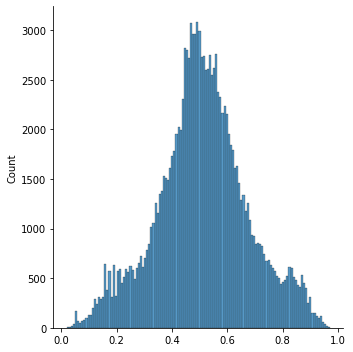

In [55]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [56]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('/content/gdrive/MyDrive/Practical ML/Project_02/submission.csv', index=False)

In [62]:
final_sub.head()

,ID,pred
0,2023_1101_1102,0.543649
1,2023_1101_1103,0.440591
2,2023_1101_1104,0.187949
3,2023_1101_1105,0.498429
4,2023_1101_1106,0.771331
